## 1. Prepare data

In [87]:
# import basic Python libraries
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# import machine learning packages
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, SelectPercentile
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
#from sklearn.cross_validation import StratifiOf the new features, the majority don't have any correlations that would be useful (or not intuitive). One that sticks out as possibly important is the category_code feature is negatively correlated with cost, regular_price, and current_price. A set of new correlations of note are the correlations between date (like week and month) and seasonality with ratio and promo1. These correlations could be useful in creating a robust machine learning algorithm for predicting future sales.
#Create the features and target data along with splitting into training and testing data.edShuffleSplit

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

# import necessary seasonality decomposition and ARIMA modeling packages
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

In [88]:
# import transactional sales data of articles into a pandas dataframe
sales_data = pd.read_csv("/var/lib/hadoop-hdfs/CristinaG/Datasets/sales.txt", sep = ";", parse_dates=['retailweek'])

# import attribute data of sold articles
attribute_data = pd.read_csv("/var/lib/hadoop-hdfs/CristinaG/Datasets/articles.txt", sep = ";")

data_joined = pd.merge(sales_data, attribute_data, how = 'inner', on = 'article')
data_joined.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,category,productgroup,cost
0,Germany,AA1821,62,31.95,25.95,0.812207,2014-12-28,1,0,RUNNING,T-SHIRTS,3.2
1,Germany,AA1821,29,31.95,22.95,0.718310,2015-01-04,0,0,RUNNING,T-SHIRTS,3.2
2,Germany,AA1821,58,31.95,28.95,0.906103,2015-01-11,0,0,RUNNING,T-SHIRTS,3.2
3,Germany,AA1821,49,31.95,29.95,0.937402,2015-01-18,0,0,RUNNING,T-SHIRTS,3.2
4,Germany,AA1821,883,31.95,24.95,0.780908,2015-01-25,0,0,RUNNING,T-SHIRTS,3.2


To have a clearer picture on the data and be able to draw some valuable conclusions we are going to add new features to the dataset.

In [89]:
# create date columns
data_joined['week'] = data_joined['retailweek'].dt.week
data_joined['month'] = data_joined['retailweek'].dt.month
data_joined['year'] = data_joined['retailweek'].dt.year

In [90]:
# create season column
data_joined['season'] = data_joined['retailweek'].apply(lambda dt: (dt.month%12 + 3)/3)

In [5]:
# country
data_joined['country'] = pd.Categorical(data_joined['country'])
data_joined['country_code'] = data_joined.country.cat.codes

In [6]:
# clothing category
data_joined['category'] = pd.Categorical(data_joined['category'])
data_joined['category_code'] = data_joined.category.cat.codes

In [7]:
# product group of clothing
data_joined['productgroup'] = pd.Categorical(data_joined['productgroup'])
data_joined['productgroup_code'] = data_joined.productgroup.cat.codes

In [8]:
# profit margin
data_joined['profit'] = data_joined['current_price'] - data_joined['cost']

In [9]:
data_joined['total_profit'] = data_joined['profit']*data_joined['sales']
data_joined

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,category,...,cost,week,month,year,season,country_code,category_code,productgroup_code,profit,total_profit
0,Germany,AA1821,62,31.95,25.95,0.812207,2014-12-28,1,0,RUNNING,...,3.2,52,12,2014,1,2,15,5,22.75,1410.50
1,Germany,AA1821,29,31.95,22.95,0.718310,2015-01-04,0,0,RUNNING,...,3.2,1,1,2015,1,2,15,5,19.75,572.75
2,Germany,AA1821,58,31.95,28.95,0.906103,2015-01-11,0,0,RUNNING,...,3.2,2,1,2015,1,2,15,5,25.75,1493.50
3,Germany,AA1821,49,31.95,29.95,0.937402,2015-01-18,0,0,RUNNING,...,3.2,3,1,2015,1,2,15,5,26.75,1310.75
4,Germany,AA1821,883,31.95,24.95,0.780908,2015-01-25,0,0,RUNNING,...,3.2,4,1,2015,1,2,15,5,21.75,19205.25
5,Germany,AA1821,43,31.95,31.95,1.000000,2015-02-01,0,0,RUNNING,...,3.2,5,2,2015,1,2,15,5,28.75,1236.25
6,Germany,AA1821,67,31.95,28.95,0.906103,2015-02-08,0,0,RUNNING,...,3.2,6,2,2015,1,2,15,5,25.75,1725.25
7,Germany,AA1821,173,31.95,15.95,0.499218,2015-02-15,0,0,RUNNING,...,3.2,7,2,2015,1,2,15,5,12.75,2205.75
8,Germany,AA1821,53,31.95,22.95,0.718310,2015-02-22,0,0,RUNNING,...,3.2,8,2,2015,1,2,15,5,19.75,1046.75
9,Germany,AA1821,19,31.95,26.95,0.843505,2015-03-01,0,0,RUNNING,...,3.2,9,3,2015,2,2,15,5,23.75,451.25


## 2. Identify the most frequently sold articles

In order to better understand how to analyze the buying behavior of our customers, let's first focus on the most frequently sold article. 

In [10]:
data_grouped = data_joined.groupby(['category', 'productgroup', 'article']).agg(['count'])
data_grouped.max()

country            count    369
sales              count    369
regular_price      count    369
current_price      count    369
ratio              count    369
retailweek         count    369
promo1             count    369
promo2             count    369
cost               count    369
week               count    369
month              count    369
year               count    369
season             count    369
country_code       count    369
category_code      count    369
productgroup_code  count    369
profit             count    369
total_profit       count    369
dtype: int64

In [11]:
data_grouped.max

<bound method DataFrame.max of                                                 country sales regular_price  \
                                                  count count         count   
category           productgroup         article                               
ACTION SPORTS      SHOES                DM6271      123   123           123   
                                        QB1247      123   123           123   
ACTIVE CASUAL      SHOES                PU1185      123   123           123   
                                        YS6935      123   123           123   
BASKETBALL GENERIC SHOES                NJ3895      123   123           123   
                                        WO1329      123   123           123   
                                        YI3589      123   123           123   
                   SHORTS               QV8877      123   123           123   
                                        RE3197      123   123           123   
CLASSICS           SH

From the observations we can conclude that there are multiple articles that have the same transactional frequency within the dataset. For the purpose of this analysis I will focus on the 'EZ8648' article: T-Shirts in the Training category.

## 3. Select all clothing data for the 'EZ8648' article

During this presentation we are going to analyze how is sales data behaving for this particular article. The same type of analysis can be applied to other articles and than to the entire dataset we have available.


In [27]:
data_EZ8648 = data_joined[data_joined['article']=='EZ8648']
data_EZ8648.head(100)


,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,category,...,cost,week,month,year,season,country_code,category_code,productgroup_code,profit,total_profit
14760,Austria,EZ8648,5,25.95,20.95,0.807322,2014-12-28,1,0,TRAINING,...,2.5,52,12,2014,1,0,20,5,18.45,92.25
14761,Austria,EZ8648,5,25.95,13.95,0.537572,2015-01-04,0,0,TRAINING,...,2.5,1,1,2015,1,0,20,5,11.45,57.25
14762,Austria,EZ8648,5,25.95,21.95,0.845857,2015-01-11,0,0,TRAINING,...,2.5,2,1,2015,1,0,20,5,19.45,97.25
14763,Austria,EZ8648,1,25.95,19.95,0.768786,2015-01-18,0,0,TRAINING,...,2.5,3,1,2015,1,0,20,5,17.45,17.45
14764,Austria,EZ8648,10,25.95,19.95,0.768786,2015-01-25,0,0,TRAINING,...,2.5,4,1,2015,1,0,20,5,17.45,174.50
14765,Austria,EZ8648,27,25.95,16.95,0.653179,2015-02-01,0,0,TRAINING,...,2.5,5,2,2015,1,0,20,5,14.45,390.15
14766,Austria,EZ8648,4,25.95,17.95,0.691715,2015-02-08,0,0,TRAINING,...,2.5,6,2,2015,1,0,20,5,15.45,61.80
14767,Austria,EZ8648,1,25.95,21.95,0.845857,2015-02-15,0,0,TRAINING,...,2.5,7,2,2015,1,0,20,5,19.45,19.45
14768,Austria,EZ8648,11,25.95,13.95,0.537572,2015-02-22,0,0,TRAINING,...,2.5,8,2,2015,1,0,20,5,11.45,125.95
14769,Austria,EZ8648,15,25.95,16.95,0.653179,2015-03-01,0,0,TRAINING,...,2.5,9,3,2015,2,0,20,5,14.45,216.75


In [28]:
data_EZ8648.shape

(369, 21)

In [29]:
data_EZ8648.describe()



,sales,regular_price,current_price,ratio,promo1,promo2,cost,week,month,year,season,country_code,category_code,productgroup_code,profit,total_profit
count,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.0,369.000000,369.000000,369.000000,369.000000,369.000000,369.0,369.0,369.000000,369.000000
mean,40.848238,25.616667,13.641057,0.532631,0.065041,0.010840,2.5,24.504065,5.943089,2015.707317,2.349593,1.000000,20.0,5.0,11.141057,342.140515
std,71.442769,0.472045,4.758511,0.186173,0.246932,0.103691,0.0,15.613212,3.532383,0.719281,1.105695,0.817605,0.0,0.0,4.758511,526.180746
min,1.000000,24.950000,7.950000,0.306358,0.000000,0.000000,2.5,1.000000,1.000000,2014.000000,1.000000,0.000000,20.0,5.0,5.450000,11.450000
25%,8.000000,24.950000,8.950000,0.344894,0.000000,0.000000,2.5,11.000000,3.000000,2015.000000,1.000000,0.000000,20.0,5.0,6.450000,94.150000
50%,19.000000,25.950000,12.950000,0.519038,0.000000,0.000000,2.5,23.000000,5.000000,2016.000000,2.000000,1.000000,20.0,5.0,10.450000,201.650000
75%,47.000000,25.950000,17.950000,0.691715,0.000000,0.000000,2.5,38.000000,9.000000,2016.000000,3.000000,2.000000,20.0,5.0,15.450000,387.000000
max,858.000000,25.950000,25.950000,1.000000,1.000000,1.000000,2.5,53.000000,12.000000,2017.000000,4.000000,2.000000,20.0,5.0,23.450000,4676.100000


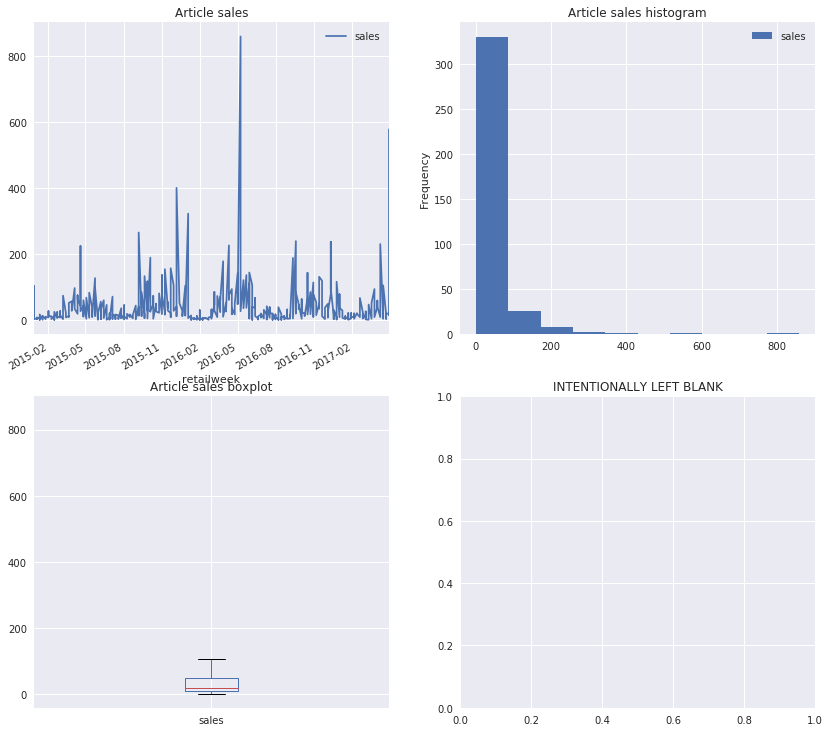

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (14,14))
data_EZ8648.plot(ax = axes[0,0], x = 'retailweek', y = 'sales')
axes[0,0].set_title('Article sales')

data_EZ8648.plot(ax = axes[0,1], y = 'sales', kind = 'hist')
axes[0,1].set_title('Article sales histogram')

data_EZ8648.plot(ax = axes[1,0], y = 'sales', kind = 'box')
axes[1,0].set_title('Article sales boxplot')

axes[1,1].set_title('INTENTIONALLY LEFT BLANK')
plt.show()

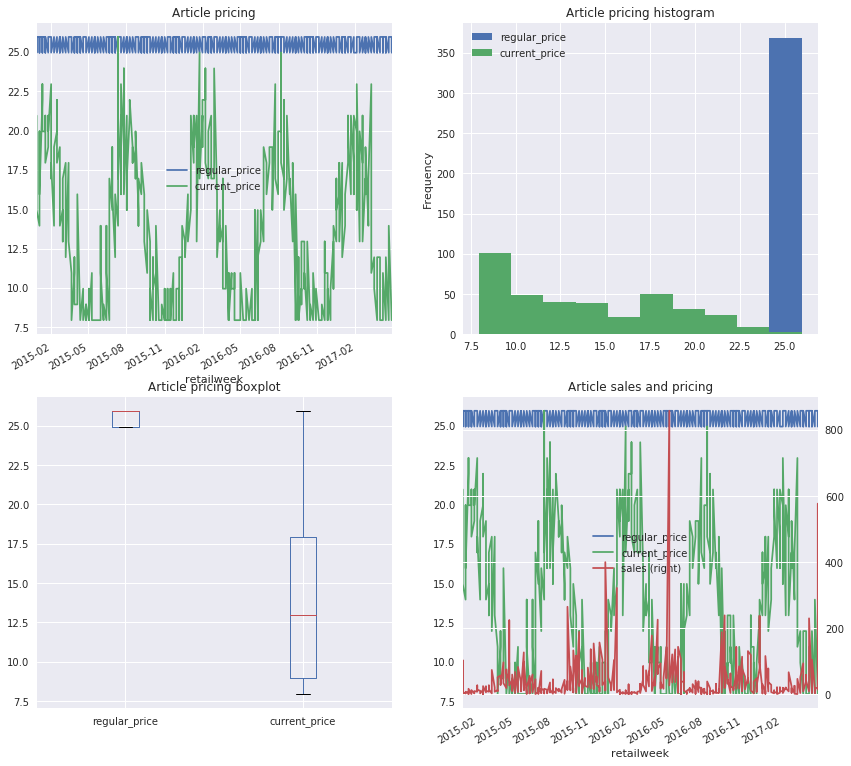

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (14,14))
data_EZ8648.plot(ax = axes[0,0], x = 'retailweek', y = ['regular_price', 'current_price'])
axes[0,0].set_title('Article pricing')

data_EZ8648.plot(ax = axes[0,1], y = ['regular_price', 'current_price'], kind = 'hist')
axes[0,1].set_title('Article pricing histogram')

data_EZ8648.plot(ax = axes[1,0], y = ['regular_price', 'current_price'], kind = 'box')
axes[1,0].set_title('Article pricing boxplot')

data_EZ8648.plot(ax = axes[1,1], x = 'retailweek', y = ['regular_price', 'current_price'])
data_EZ8648.plot(ax = axes[1,1], secondary_y = True, x = 'retailweek', y = 'sales')
axes[1,1].set_title('Article sales and pricing')
plt.show()

I can see a lot of correlation between the sales and when the current price drops with this subset of data for article  sales (article ID EZ8648).



## 3. Identify what is driving sales and forecast future sales

### Transactional sales data correlation matrix

To better understand the correlation between price ratio, promotions and sales, let build the correlation matrix

In [34]:
correlated_sales = data_EZ8648.corr()
correlated_sales

,sales,regular_price,current_price,ratio,promo1,promo2,cost,week,month,year,season,country_code,category_code,productgroup_code,profit,total_profit
sales,1.000000,2.428052e-02,-0.333153,-0.334427,2.767097e-02,-2.362071e-02,NaN,1.430749e-01,1.233106e-01,2.224205e-02,6.737509e-02,-2.088799e-02,NaN,NaN,-0.333153,0.908740
regular_price,0.024281,1.000000e+00,0.016937,-0.036293,-1.908813e-17,7.402332e-02,NaN,-3.431930e-16,7.309589e-17,-9.489694e-16,1.783197e-16,-8.660254e-01,NaN,NaN,0.016937,0.063990
current_price,-0.333153,1.693660e-02,1.000000,0.998403,1.952184e-01,6.738654e-02,NaN,-2.950001e-01,-3.407049e-01,5.052111e-02,-3.466276e-01,-1.396907e-03,NaN,NaN,1.000000,-0.166700
ratio,-0.334427,-3.629270e-02,0.998403,1.000000,1.946898e-01,6.245134e-02,NaN,-2.951977e-01,-3.411948e-01,5.097647e-02,-3.463428e-01,4.450135e-02,NaN,NaN,0.998403,-0.170621
promo1,0.027671,-1.908813e-17,0.195218,0.194690,1.000000e+00,7.851833e-02,NaN,2.719940e-01,2.098679e-01,-1.373218e-01,-8.350518e-02,3.735775e-19,NaN,NaN,0.195218,0.112531
promo2,-0.023621,7.402332e-02,0.067387,0.062451,7.851833e-02,1.000000e+00,NaN,3.329701e-03,-7.992006e-02,6.220547e-03,-5.684529e-02,-1.445682e-18,NaN,NaN,0.067387,-0.025401
cost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
week,0.143075,-3.431930e-16,-0.295000,-0.295198,2.719940e-01,3.329701e-03,NaN,1.000000e+00,9.120859e-01,-2.866282e-01,5.573751e-01,9.075232e-18,NaN,NaN,-0.295000,0.158145
month,0.123311,7.309589e-17,-0.340705,-0.341195,2.098679e-01,-7.992006e-02,NaN,9.120859e-01,1.000000e+00,-3.338445e-01,6.333641e-01,0.000000e+00,NaN,NaN,-0.340705,0.099775
year,0.022242,-9.489694e-16,0.050521,0.050976,-1.373218e-01,6.220547e-03,NaN,-2.866282e-01,-3.338445e-01,1.000000e+00,-2.195080e-01,0.000000e+00,NaN,NaN,0.050521,0.014986


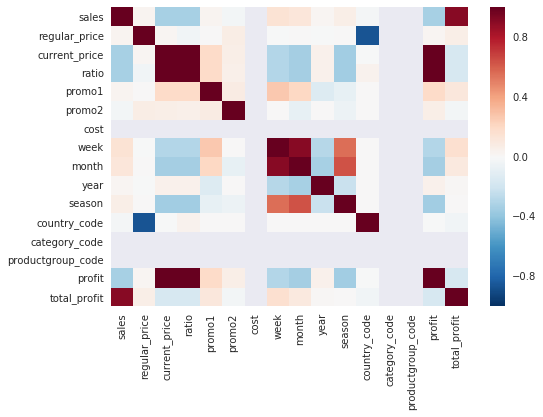

In [35]:
# plot the heatmap
sns.heatmap(correlated_sales)
plt.show()

The two price variables (regular and current price) are heavily correlated which makes a lot of sense. Regular price is heavily correlated with cost which makes perfect sense and current price is also positively correlated with cost. Ratio looks to be moderately correlated with the current_price which again makes sense since it is the results of regular_price/current_price. Ratio looks to be moderately negatively correlated with sales which would imply that as the ratio goes down, the sales go up; this intuitively makes sense since reduced prices hypothetically make for more purchases.

Lastly, it looks like promo1 is loosely correlated with sales; more so than promo2's correlation with sales.
At this point, it isn't very clear which promotion drives sales more. I would hazard a guess that promo1 does influence sales more based on the more positive correlation. As far as pricing goes, it looks like the like there is a strong correlation between reducing the ratio (decreasing the current_price) and increasing profit and a negatively correlation between ratio and the total of units sold.

I think the best approach would be to prepare the joined sales data for applying machine learning for a numerical output (not a classifer). It looks like some form of ordinary least squares regression, logistic regression, lasso regression, ARIMA, or random forest regression will be the best way to approach this problem.

### Machine Learning: Regression

Steps required for adequately performing machine learning on sales data using a Pipeline for evaluating many different combinations of features/algorithms and using proper validation technique(s) like cross-validation:

#### A. Feature creation (Ideas listed below for creating new variables to help with machine learning, re-run correlation matrix with the new features):
- month (1 through 12)
- season (1 through 4: winter, spring, summer, fall)
- type of clothing (convert to a unique number for each article of clothing)
- country number (convert country variable to a unique number)

#### B. Split data into features (data, ~ X) and target (sales ~ Y) for machine learning regressions. Take the features and targets and split into training and testing data as well so I can properly evaluate my results against 'new' data so I can better judge the performance.

#### C. Use a SKLearn Pipeline for steps 1 through 5
- Transform data (feature scaling, etc.)
- Dimensionality reduction (PCA)
- Feature selection (k-best, k-means, etc.)
- Machine learning algorithm selection (evaluate different combinations and machine learning algorithms while using cross-validation methods to ensure valid results)
- Evaluate results using the following metrics: accuracy, precision, recall

#### A. Feature Creation
These features were created earlier in the data preparation phase and are already included in the dataset.

Create the features and target data along with splitting into training and testing data.

#### B. Create Feature and Target Data and Training/Testing Data Subsets

SKLearn machine learning functions receive lists and generally can handle numpy arrays so I'll split out the data into two lists: 1 for the target (Y) which is the sales column and 1 for the features (X) which are all of the other columns that are numerical.

In [36]:
# define features I want to use and what the target data is
feature_list = ['regular_price', 'current_price', 'ratio', 'promo1', 'promo2', 'cost', 'week', 'month', 'year', \
               'season', 'country_code', 'category_code', 'productgroup_code', 'profit', 'total_profit']
target_list = ['sales']

In [37]:
# subset joined dataframe into df_features and target
df_features = data_EZ8648[feature_list]
df_features.head()

,regular_price,current_price,ratio,promo1,promo2,cost,week,month,year,season,country_code,category_code,productgroup_code,profit,total_profit
14760,25.95,20.95,0.807322,1,0,2.5,52,12,2014,1,0,20,5,18.45,92.25
14761,25.95,13.95,0.537572,0,0,2.5,1,1,2015,1,0,20,5,11.45,57.25
14762,25.95,21.95,0.845857,0,0,2.5,2,1,2015,1,0,20,5,19.45,97.25
14763,25.95,19.95,0.768786,0,0,2.5,3,1,2015,1,0,20,5,17.45,17.45
14764,25.95,19.95,0.768786,0,0,2.5,4,1,2015,1,0,20,5,17.45,174.50


In [41]:
df_features.shape

(369, 15)

In [44]:
target = data_EZ8648[target_list]
target.head()

,sales
14760,5
14761,5
14762,5
14763,1
14764,10


In [45]:
target.shape

(369, 1)

Subsetted dataframes look good, now split the data into train and testing splits. Generally, a 80%/20% or 70%/30% training/testing data split works so I'm going to start with 70/30 to maximize my testing data so I have the best possible idea of performance for new data since that is the goal of this case study.

In [46]:
feature_train, feature_test, target_train, target_test = train_test_split(df_features, target, test_size=0.3, random_state=42)

Check sizing of created feature and target train/test splits

In [47]:
print(feature_train.shape, feature_test.shape, target_train.shape, target_test.shape)

((258, 15), (111, 15), (258, 1), (111, 1))


In [48]:
print(type(feature_train), type(feature_test), type(target_train), type(target_train))

(<class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>)


Training and testing data looks good. Next, I'll set up the SKLearn Pipeline for performing regressions.

#### C. Pipeline: Use a pipeline for finding and evaluating the best feature scaler, dimensionality reduction, feature selection, and machine learning algorithm

Create regressors, scalers, etc. for use in Pipeline


In [100]:
#regressions
#LinReg = LinearRegression()
#Las = Lasso() # optimize with GridSearchCV: alpha=[0.1, 0.3, 0.5, 0.7, 0.9, 1] (default=1)
#DTree = DecisionTreeRegressor(random_state = 42)  # min_samples_leaf (default=1), min_samples_split (default=2)
RF = RandomForestRegressor(random_state = 42) # n_estimators (default=10), min_samples_leaf (default=1), min_samples_split (default=2)

# feature scaling
minMaxScaler = MinMaxScaler()
stdScaler = StandardScaler()

# dimensionality reduction and feature selection
PCAreducer = PCA(svd_solver = 'auto', random_state = 42)
KBestSelector = SelectKBest(f_regression) # optimize: k = [3, 5, 7, 10, 13, 15] (default = 10)

Create Pipeline including the machine learning tools I want to evaluate and the parameters I want to optimize for each of the tools used.

Use StratifiedShuffleSplit for cross-validation and GridSearchCV for parameter optimization within pipeline. I chose to optimize around r^2 since it encompasses a lot of quality of fit within 1 performance metric.

In [101]:
# convert features and target to numpy arrays
target_np = target.as_matrix(columns = target_list).ravel()
df_features_np = df_features.as_matrix(columns = feature_list)
target_train_np = target_train.as_matrix(columns = target_list).ravel()
feature_train_np = feature_train.as_matrix(columns = target_list)

In [102]:
# create machine learning pipeline
pipeline = Pipeline([('scaler', minMaxScaler), ('PCA', PCAreducer), ('KBest', KBestSelector), ('reg', RF)])

# create parameters of GridSearchCV using pipeline
params = {
    'KBest__k': [3, 5, 8, 10, 15],
    'reg__n_estimators': [3, 5, 8, 10, 15],
    'reg__min_samples_split': [2, 4, 6, 8, 10, 12],
    'reg__min_samples_leaf': [1, 2, 4, 6, 8]
}

gridSearch = GridSearchCV(pipeline, param_grid = params, scoring = 'r2', verbose = 10) # scoring = 'r2',

# fit pipeline and grid search to training features and target dataset
gridSearch.fit(feature_train, target_train_np)

# store the best estimator (best classifier with parameters)
regr = gridSearch.best_estimator_

Fitting 3 folds for each of 750 candidates, totalling 2250 fits
[CV] reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2, score=-0.092008, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2, score=0.635385, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2, score=0.596039, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2, score=0.537836, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg_

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s


[CV] reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2, score=0.659937, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2, score=0.257411, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2, score=0.511150, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2, score=0.639912, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=1, reg__min_

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s remaining:    0.0s


[CV] reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2, score=0.341998, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2, score=0.626456, total=   0.0s
[CV] reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2, score=0.437441, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2, score=0.364659, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=1, r

[CV]  reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=8, score=-0.231844, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=8 
[CV]  reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=8, score=0.605412, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=8 
[CV]  reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=8, score=0.528453, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=8 
[CV]  reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=8, score=0.201043, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=8 
[CV]  reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=1, reg__min_samples_split=8, score=0.496466, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=3, 

[CV]  reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=2, score=0.589059, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=2 
[CV]  reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=2, score=0.211339, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=2 
[CV]  reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=2, score=0.477928, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=2 
[CV]  reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=2, score=0.568938, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=2 
[CV]  reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=2, score=-0.245378, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=3, reg__

[CV]  reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=6, score=0.491590, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=6 
[CV]  reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=6, score=0.600902, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=6 
[CV]  reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=6, score=0.521485, total=   0.1s
[CV] reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=8 
[CV]  reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=8, score=-0.895973, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=8 
[CV]  reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=8, score=0.655284, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=3, 

[CV]  reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=12, score=0.487843, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=12 
[CV]  reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=12, score=0.133060, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=12 
[CV]  reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=12, score=0.571432, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=12 
[CV]  reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=12, score=0.471354, total=   0.0s
[CV] reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=12 
[CV]  reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=2, reg__min_samples_split=12, score=0.445729, total=   0.1s
[CV] reg__n_estimators=15, 

[CV]  reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=4, reg__min_samples_split=6, score=0.503845, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=4, reg__min_samples_split=6 
[CV]  reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=4, reg__min_samples_split=6, score=0.137448, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=4, reg__min_samples_split=6 
[CV]  reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=4, reg__min_samples_split=6, score=0.589325, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=4, reg__min_samples_split=6 
[CV]  reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=4, reg__min_samples_split=6, score=0.475983, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=4, reg__min_samples_split=6 
[CV]  reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=4, reg__min_samples_split=6, score=0.465804, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=3, reg__m

[CV]  reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=4, reg__min_samples_split=10, score=0.705843, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=4, reg__min_samples_split=10 
[CV]  reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=4, reg__min_samples_split=10, score=0.433219, total=   0.1s
[CV] reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=4, reg__min_samples_split=12 
[CV]  reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=4, reg__min_samples_split=12, score=-0.080212, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=4, reg__min_samples_split=12 
[CV]  reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=4, reg__min_samples_split=12, score=0.675394, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=4, reg__min_samples_split=12 
[CV]  reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=4, reg__min_samples_split=12, score=0.481016, total=   0.0s
[CV] reg__n_estimators=5, KBest

[CV]  reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=6, reg__min_samples_split=4, score=0.693421, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=6, reg__min_samples_split=4 
[CV]  reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=6, reg__min_samples_split=4, score=0.378897, total=   0.0s
[CV] reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=6, reg__min_samples_split=4 
[CV]  reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=6, reg__min_samples_split=4, score=0.443383, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=6, reg__min_samples_split=4 
[CV]  reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=6, reg__min_samples_split=4, score=0.754306, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=6, reg__min_samples_split=4 
[CV]  reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=6, reg__min_samples_split=4, score=0.378493, total=   0.1s
[CV] reg__n_estimators=3, KBest__k=

[CV]  reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=6, reg__min_samples_split=10, score=0.449416, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=6, reg__min_samples_split=10 
[CV]  reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=6, reg__min_samples_split=10, score=0.717669, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=6, reg__min_samples_split=10 
[CV]  reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=6, reg__min_samples_split=10, score=0.393643, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=6, reg__min_samples_split=10 
[CV]  reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=6, reg__min_samples_split=10, score=0.404472, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=6, reg__min_samples_split=10 
[CV]  reg__n_estimators=10, KBest__k=3, reg__min_samples_leaf=6, reg__min_samples_split=10, score=0.693421, total=   0.0s
[CV] reg__n_estimators=10, KBes

[CV]  reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=8, reg__min_samples_split=4, score=0.364108, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=8, reg__min_samples_split=4 
[CV]  reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=8, reg__min_samples_split=4, score=0.442000, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=8, reg__min_samples_split=4 
[CV]  reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=8, reg__min_samples_split=4, score=0.710835, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=8, reg__min_samples_split=4 
[CV]  reg__n_estimators=5, KBest__k=3, reg__min_samples_leaf=8, reg__min_samples_split=4, score=0.347411, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=8, reg__min_samples_split=4 
[CV]  reg__n_estimators=8, KBest__k=3, reg__min_samples_leaf=8, reg__min_samples_split=4, score=0.463267, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=3, reg__m

[CV]  reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=8, reg__min_samples_split=8, score=0.431122, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=8, reg__min_samples_split=8 
[CV]  reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=8, reg__min_samples_split=8, score=0.779532, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=8, reg__min_samples_split=8 
[CV]  reg__n_estimators=15, KBest__k=3, reg__min_samples_leaf=8, reg__min_samples_split=8, score=0.337203, total=   0.1s
[CV] reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=8, reg__min_samples_split=10 
[CV]  reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=8, reg__min_samples_split=10, score=0.523216, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=8, reg__min_samples_split=10 
[CV]  reg__n_estimators=3, KBest__k=3, reg__min_samples_leaf=8, reg__min_samples_split=10, score=0.795397, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=

[CV]  reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=1, reg__min_samples_split=2, score=0.513217, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=1, reg__min_samples_split=2, score=0.608139, total=   0.0s
[CV] reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=1, reg__min_samples_split=2, score=-0.237274, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=1, reg__min_samples_split=2, score=0.444808, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=1, reg__min_samples_split=2, score=0.632445, total=   0.1s
[CV] reg__n_estimators=3, KBest__k

[CV]  reg__n_estimators=8, KBest__k=5, reg__min_samples_leaf=1, reg__min_samples_split=8, score=0.540668, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=1, reg__min_samples_split=8 
[CV]  reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=1, reg__min_samples_split=8, score=0.195212, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=1, reg__min_samples_split=8 
[CV]  reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=1, reg__min_samples_split=8, score=0.568250, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=1, reg__min_samples_split=8 
[CV]  reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=1, reg__min_samples_split=8, score=0.532977, total=   0.0s
[CV] reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=1, reg__min_samples_split=8 
[CV]  reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=1, reg__min_samples_split=8, score=-0.157496, total=   0.1s
[CV] reg__n_estimators=15, KBest__k

[CV]  reg__n_estimators=3, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=2, score=0.527686, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=2 
[CV]  reg__n_estimators=5, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=2, score=0.202668, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=2 
[CV]  reg__n_estimators=5, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=2, score=0.683523, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=2 
[CV]  reg__n_estimators=5, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=2, score=0.536720, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=2 
[CV]  reg__n_estimators=8, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=2, score=-0.242849, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=5, reg__

[CV]  reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=6, score=0.512920, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=6 
[CV]  reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=6, score=0.667935, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=6 
[CV]  reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=6, score=0.536302, total=   0.1s
[CV] reg__n_estimators=3, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=8 
[CV]  reg__n_estimators=3, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=8, score=-0.881532, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=8 
[CV]  reg__n_estimators=3, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=8, score=0.704783, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=5, 

[CV]  reg__n_estimators=8, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=12, score=0.499505, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=12 
[CV]  reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=12, score=0.145415, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=12 
[CV]  reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=12, score=0.610477, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=12 
[CV]  reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=12, score=0.481826, total=   0.0s
[CV] reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=12 
[CV]  reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=2, reg__min_samples_split=12, score=0.455214, total=   0.1s
[CV] reg__n_estimators=15, 

[CV]  reg__n_estimators=3, KBest__k=5, reg__min_samples_leaf=4, reg__min_samples_split=6, score=0.512206, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=5, reg__min_samples_leaf=4, reg__min_samples_split=6 
[CV]  reg__n_estimators=5, KBest__k=5, reg__min_samples_leaf=4, reg__min_samples_split=6, score=0.131059, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=5, reg__min_samples_leaf=4, reg__min_samples_split=6 
[CV]  reg__n_estimators=5, KBest__k=5, reg__min_samples_leaf=4, reg__min_samples_split=6, score=0.631029, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=5, reg__min_samples_leaf=4, reg__min_samples_split=6 
[CV]  reg__n_estimators=5, KBest__k=5, reg__min_samples_leaf=4, reg__min_samples_split=6, score=0.465633, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=5, reg__min_samples_leaf=4, reg__min_samples_split=6 
[CV]  reg__n_estimators=8, KBest__k=5, reg__min_samples_leaf=4, reg__min_samples_split=6, score=0.453874, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=5, reg__m

[CV] reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=4, reg__min_samples_split=10 
[CV]  reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=4, reg__min_samples_split=10, score=0.453271, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=4, reg__min_samples_split=10 
[CV]  reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=4, reg__min_samples_split=10, score=0.422469, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=4, reg__min_samples_split=10 
[CV]  reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=4, reg__min_samples_split=10, score=0.752073, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=4, reg__min_samples_split=10 
[CV]  reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=4, reg__min_samples_split=10, score=0.443697, total=   0.1s
[CV] reg__n_estimators=3, KBest__k=5, reg__min_samples_leaf=4, reg__min_samples_split=12 
[CV]  reg__n_estimators=3, KBest__k=5, reg__min_samples_le

[CV]  reg__n_estimators=8, KBest__k=5, reg__min_samples_leaf=6, reg__min_samples_split=4, score=0.397263, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=6, reg__min_samples_split=4 
[CV]  reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=6, reg__min_samples_split=4, score=0.401703, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=6, reg__min_samples_split=4 
[CV]  reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=6, reg__min_samples_split=4, score=0.743920, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=6, reg__min_samples_split=4 
[CV]  reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=6, reg__min_samples_split=4, score=0.381907, total=   0.0s
[CV] reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=6, reg__min_samples_split=4 
[CV]  reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=6, reg__min_samples_split=4, score=0.441339, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=

[CV]  reg__n_estimators=8, KBest__k=5, reg__min_samples_leaf=6, reg__min_samples_split=10, score=0.397263, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=6, reg__min_samples_split=10 
[CV]  reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=6, reg__min_samples_split=10, score=0.401703, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=6, reg__min_samples_split=10 
[CV]  reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=6, reg__min_samples_split=10, score=0.743920, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=6, reg__min_samples_split=10 
[CV]  reg__n_estimators=10, KBest__k=5, reg__min_samples_leaf=6, reg__min_samples_split=10, score=0.381907, total=   0.0s
[CV] reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=6, reg__min_samples_split=10 
[CV]  reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=6, reg__min_samples_split=10, score=0.441339, total=   0.1s
[CV] reg__n_estimators=15, 

[CV]  reg__n_estimators=3, KBest__k=5, reg__min_samples_leaf=8, reg__min_samples_split=4, score=0.367594, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=5, reg__min_samples_leaf=8, reg__min_samples_split=4 
[CV]  reg__n_estimators=5, KBest__k=5, reg__min_samples_leaf=8, reg__min_samples_split=4, score=0.432466, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=5, reg__min_samples_leaf=8, reg__min_samples_split=4 
[CV]  reg__n_estimators=5, KBest__k=5, reg__min_samples_leaf=8, reg__min_samples_split=4, score=0.736791, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=5, reg__min_samples_leaf=8, reg__min_samples_split=4 
[CV]  reg__n_estimators=5, KBest__k=5, reg__min_samples_leaf=8, reg__min_samples_split=4, score=0.350920, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=5, reg__min_samples_leaf=8, reg__min_samples_split=4 
[CV]  reg__n_estimators=8, KBest__k=5, reg__min_samples_leaf=8, reg__min_samples_split=4, score=0.458491, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=5, reg__m

[CV]  reg__n_estimators=15, KBest__k=5, reg__min_samples_leaf=8, reg__min_samples_split=8, score=0.339231, total=   0.1s
[CV] reg__n_estimators=3, KBest__k=5, reg__min_samples_leaf=8, reg__min_samples_split=10 
[CV]  reg__n_estimators=3, KBest__k=5, reg__min_samples_leaf=8, reg__min_samples_split=10, score=0.515227, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=5, reg__min_samples_leaf=8, reg__min_samples_split=10 
[CV]  reg__n_estimators=3, KBest__k=5, reg__min_samples_leaf=8, reg__min_samples_split=10, score=0.822873, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=5, reg__min_samples_leaf=8, reg__min_samples_split=10 
[CV]  reg__n_estimators=3, KBest__k=5, reg__min_samples_leaf=8, reg__min_samples_split=10, score=0.367594, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=5, reg__min_samples_leaf=8, reg__min_samples_split=10 
[CV]  reg__n_estimators=5, KBest__k=5, reg__min_samples_leaf=8, reg__min_samples_split=10, score=0.432466, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=

[CV]  reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=1, reg__min_samples_split=2, score=0.535339, total=   0.0s
[CV] reg__n_estimators=15, KBest__k=8, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=15, KBest__k=8, reg__min_samples_leaf=1, reg__min_samples_split=2, score=0.349268, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=8, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=15, KBest__k=8, reg__min_samples_leaf=1, reg__min_samples_split=2, score=0.565155, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=8, reg__min_samples_leaf=1, reg__min_samples_split=2 
[CV]  reg__n_estimators=15, KBest__k=8, reg__min_samples_leaf=1, reg__min_samples_split=2, score=0.528536, total=   0.1s
[CV] reg__n_estimators=3, KBest__k=8, reg__min_samples_leaf=1, reg__min_samples_split=4 
[CV]  reg__n_estimators=3, KBest__k=8, reg__min_samples_leaf=1, reg__min_samples_split=4, score=-1.248966, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=8

[CV]  reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=1, reg__min_samples_split=8, score=0.192755, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=1, reg__min_samples_split=8 
[CV]  reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=1, reg__min_samples_split=8, score=0.565921, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=1, reg__min_samples_split=8 
[CV]  reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=1, reg__min_samples_split=8, score=0.531123, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=8, reg__min_samples_leaf=1, reg__min_samples_split=8 
[CV]  reg__n_estimators=15, KBest__k=8, reg__min_samples_leaf=1, reg__min_samples_split=8, score=0.302220, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=8, reg__min_samples_leaf=1, reg__min_samples_split=8 
[CV]  reg__n_estimators=15, KBest__k=8, reg__min_samples_leaf=1, reg__min_samples_split=8, score=0.527218, total=   0.1s
[CV] reg__n_estimators=15, KBest__k

[CV]  reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=2, reg__min_samples_split=2, score=-0.208229, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=2, reg__min_samples_split=2 
[CV]  reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=2, reg__min_samples_split=2, score=0.770462, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=2, reg__min_samples_split=2 
[CV]  reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=2, reg__min_samples_split=2, score=0.555513, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=2, reg__min_samples_split=2 
[CV]  reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=2, reg__min_samples_split=2, score=0.231445, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=2, reg__min_samples_split=2 
[CV]  reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=2, reg__min_samples_split=2, score=0.687607, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=8, 

[CV]  reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=2, reg__min_samples_split=8, score=-0.187545, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=2, reg__min_samples_split=8 
[CV]  reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=2, reg__min_samples_split=8, score=0.721764, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=2, reg__min_samples_split=8 
[CV]  reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=2, reg__min_samples_split=8, score=0.509510, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=2, reg__min_samples_split=8 
[CV]  reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=2, reg__min_samples_split=8, score=0.225911, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=2, reg__min_samples_split=8 
[CV]  reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=2, reg__min_samples_split=8, score=0.644395, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=8, 

[CV] reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=2 
[CV]  reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=2, score=0.444033, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=2 
[CV]  reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=2, score=0.735599, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=2 
[CV]  reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=2, score=0.469751, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=2 
[CV]  reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=2, score=0.465579, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=2 
[CV]  reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=4, reg__mi

[CV]  reg__n_estimators=5, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=8, score=0.610800, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=8 
[CV]  reg__n_estimators=5, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=8, score=0.466133, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=8 
[CV]  reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=8, score=0.444033, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=8 
[CV]  reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=8, score=0.735599, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=8 
[CV]  reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=8, score=0.469751, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=8, reg__

[CV]  reg__n_estimators=15, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=12, score=0.744569, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=12 
[CV]  reg__n_estimators=15, KBest__k=8, reg__min_samples_leaf=4, reg__min_samples_split=12, score=0.433523, total=   0.1s
[CV] reg__n_estimators=3, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=2 
[CV]  reg__n_estimators=3, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=2, score=0.452178, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=2 
[CV]  reg__n_estimators=3, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=2, score=0.767447, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=2 
[CV]  reg__n_estimators=3, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=2, score=0.463677, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=8, 

[CV]  reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=6, score=0.405649, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=6 
[CV]  reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=6, score=0.729772, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=6 
[CV]  reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=6, score=0.382758, total=   0.0s
[CV] reg__n_estimators=15, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=6 
[CV]  reg__n_estimators=15, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=6, score=0.447556, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=6 
[CV]  reg__n_estimators=15, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=6, score=0.798767, total=   0.1s
[CV] reg__n_estimators=15, KBest__k

[CV]  reg__n_estimators=5, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=12, score=0.414216, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=12 
[CV]  reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=12, score=0.447748, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=12 
[CV]  reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=12, score=0.752413, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=12 
[CV]  reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=12, score=0.398458, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=12 
[CV]  reg__n_estimators=10, KBest__k=8, reg__min_samples_leaf=6, reg__min_samples_split=12, score=0.405649, total=   0.0s
[CV] reg__n_estimators=10, KBest_

[CV] reg__n_estimators=5, KBest__k=8, reg__min_samples_leaf=8, reg__min_samples_split=6 
[CV]  reg__n_estimators=5, KBest__k=8, reg__min_samples_leaf=8, reg__min_samples_split=6, score=0.433598, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=8, reg__min_samples_leaf=8, reg__min_samples_split=6 
[CV]  reg__n_estimators=5, KBest__k=8, reg__min_samples_leaf=8, reg__min_samples_split=6, score=0.723385, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=8, reg__min_samples_leaf=8, reg__min_samples_split=6 
[CV]  reg__n_estimators=5, KBest__k=8, reg__min_samples_leaf=8, reg__min_samples_split=6, score=0.350945, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=8, reg__min_samples_split=6 
[CV]  reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=8, reg__min_samples_split=6, score=0.462174, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=8, reg__min_samples_split=6 
[CV]  reg__n_estimators=8, KBest__k=8, reg__min_samples_leaf=8, reg__min_sa

[CV]  reg__n_estimators=15, KBest__k=8, reg__min_samples_leaf=8, reg__min_samples_split=10, score=0.332449, total=   0.1s
[CV] reg__n_estimators=3, KBest__k=8, reg__min_samples_leaf=8, reg__min_samples_split=12 
[CV]  reg__n_estimators=3, KBest__k=8, reg__min_samples_leaf=8, reg__min_samples_split=12, score=0.513314, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=8, reg__min_samples_leaf=8, reg__min_samples_split=12 
[CV]  reg__n_estimators=3, KBest__k=8, reg__min_samples_leaf=8, reg__min_samples_split=12, score=0.803487, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=8, reg__min_samples_leaf=8, reg__min_samples_split=12 
[CV]  reg__n_estimators=3, KBest__k=8, reg__min_samples_leaf=8, reg__min_samples_split=12, score=0.367607, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=8, reg__min_samples_leaf=8, reg__min_samples_split=12 
[CV]  reg__n_estimators=5, KBest__k=8, reg__min_samples_leaf=8, reg__min_samples_split=12, score=0.433598, total=   0.0s
[CV] reg__n_estimators=5, KBest__k

[CV]  reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=1, reg__min_samples_split=4, score=0.423224, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=1, reg__min_samples_split=4 
[CV]  reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=1, reg__min_samples_split=4, score=-0.645294, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=1, reg__min_samples_split=4 
[CV]  reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=1, reg__min_samples_split=4, score=0.639522, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=1, reg__min_samples_split=4 
[CV]  reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=1, reg__min_samples_split=4, score=0.443672, total=   0.0s
[CV] reg__n_estimators=15, KBest__k=10, reg__min_samples_leaf=1, reg__min_samples_split=4 
[CV]  reg__n_estimators=15, KBest__k=10, reg__min_samples_leaf=1, reg__min_samples_split=4, score=-0.775304, total=   0.1s
[CV] reg__n_estimators=15

[CV]  reg__n_estimators=5, KBest__k=10, reg__min_samples_leaf=1, reg__min_samples_split=10, score=0.452390, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=10, reg__min_samples_leaf=1, reg__min_samples_split=10 
[CV]  reg__n_estimators=5, KBest__k=10, reg__min_samples_leaf=1, reg__min_samples_split=10, score=0.468675, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=1, reg__min_samples_split=10 
[CV]  reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=1, reg__min_samples_split=10, score=-1.561993, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=1, reg__min_samples_split=10 
[CV]  reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=1, reg__min_samples_split=10, score=0.646328, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=1, reg__min_samples_split=10 
[CV]  reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=1, reg__min_samples_split=10, score=0.471029, total=   0.0s
[CV] reg__n_estimators=10

[CV]  reg__n_estimators=15, KBest__k=10, reg__min_samples_leaf=2, reg__min_samples_split=2, score=0.537046, total=   0.1s
[CV] reg__n_estimators=3, KBest__k=10, reg__min_samples_leaf=2, reg__min_samples_split=4 
[CV]  reg__n_estimators=3, KBest__k=10, reg__min_samples_leaf=2, reg__min_samples_split=4, score=-1.053642, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=10, reg__min_samples_leaf=2, reg__min_samples_split=4 
[CV]  reg__n_estimators=3, KBest__k=10, reg__min_samples_leaf=2, reg__min_samples_split=4, score=0.810686, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=10, reg__min_samples_leaf=2, reg__min_samples_split=4 
[CV]  reg__n_estimators=3, KBest__k=10, reg__min_samples_leaf=2, reg__min_samples_split=4, score=0.492435, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=10, reg__min_samples_leaf=2, reg__min_samples_split=4 
[CV]  reg__n_estimators=5, KBest__k=10, reg__min_samples_leaf=2, reg__min_samples_split=4, score=0.148859, total=   0.0s
[CV] reg__n_estimators=5, KBest__

[CV]  reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=2, reg__min_samples_split=8, score=0.507707, total=   0.0s
[CV] reg__n_estimators=15, KBest__k=10, reg__min_samples_leaf=2, reg__min_samples_split=8 
[CV]  reg__n_estimators=15, KBest__k=10, reg__min_samples_leaf=2, reg__min_samples_split=8, score=0.513990, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=10, reg__min_samples_leaf=2, reg__min_samples_split=8 
[CV]  reg__n_estimators=15, KBest__k=10, reg__min_samples_leaf=2, reg__min_samples_split=8, score=0.642385, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=10, reg__min_samples_leaf=2, reg__min_samples_split=8 
[CV]  reg__n_estimators=15, KBest__k=10, reg__min_samples_leaf=2, reg__min_samples_split=8, score=0.515945, total=   0.1s
[CV] reg__n_estimators=3, KBest__k=10, reg__min_samples_leaf=2, reg__min_samples_split=10 
[CV]  reg__n_estimators=3, KBest__k=10, reg__min_samples_leaf=2, reg__min_samples_split=10, score=-0.946889, total=   0.0s
[CV] reg__n_estimators=3,

[CV]  reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=4, reg__min_samples_split=2, score=0.446113, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=4, reg__min_samples_split=2 
[CV]  reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=4, reg__min_samples_split=2, score=0.725316, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=4, reg__min_samples_split=2 
[CV]  reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=4, reg__min_samples_split=2, score=0.484208, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=4, reg__min_samples_split=2 
[CV]  reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=4, reg__min_samples_split=2, score=0.467203, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=4, reg__min_samples_split=2 
[CV]  reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=4, reg__min_samples_split=2, score=0.686116, total=   0.0s
[CV] reg__n_estimators=10, KBes

[CV]  reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=4, reg__min_samples_split=8, score=0.446113, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=4, reg__min_samples_split=8 
[CV]  reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=4, reg__min_samples_split=8, score=0.725316, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=4, reg__min_samples_split=8 
[CV]  reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=4, reg__min_samples_split=8, score=0.484208, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=4, reg__min_samples_split=8 
[CV]  reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=4, reg__min_samples_split=8, score=0.467203, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=4, reg__min_samples_split=8 
[CV]  reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=4, reg__min_samples_split=8, score=0.686116, total=   0.0s
[CV] reg__n_estimators=10, KBes

[CV] reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=6, reg__min_samples_split=2 
[CV]  reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=6, reg__min_samples_split=2, score=0.744361, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=6, reg__min_samples_split=2 
[CV]  reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=6, reg__min_samples_split=2, score=0.385327, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=6, reg__min_samples_split=2 
[CV]  reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=6, reg__min_samples_split=2, score=0.405052, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=6, reg__min_samples_split=2 
[CV]  reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=6, reg__min_samples_split=2, score=0.722569, total=   0.1s
[CV] reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=6, reg__min_samples_split=2 
[CV]  reg__n_estimators=10, KBest__k=10, reg__min_samples_lea

[CV] reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=6, reg__min_samples_split=8 
[CV]  reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=6, reg__min_samples_split=8, score=0.744361, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=6, reg__min_samples_split=8 
[CV]  reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=6, reg__min_samples_split=8, score=0.385327, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=6, reg__min_samples_split=8 
[CV]  reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=6, reg__min_samples_split=8, score=0.405052, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=6, reg__min_samples_split=8 
[CV]  reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=6, reg__min_samples_split=8, score=0.722569, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=6, reg__min_samples_split=8 
[CV]  reg__n_estimators=10, KBest__k=10, reg__min_samples_lea

[CV]  reg__n_estimators=5, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=2, score=0.717229, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=2 
[CV]  reg__n_estimators=5, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=2, score=0.350934, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=2 
[CV]  reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=2, score=0.462174, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=2 
[CV]  reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=2, score=0.797538, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=2 
[CV]  reg__n_estimators=8, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=2, score=0.343729, total=   0.0s
[CV] reg__n_estimators=10, KBest__k

[CV]  reg__n_estimators=15, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=6, score=0.789279, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=6 
[CV]  reg__n_estimators=15, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=6, score=0.336443, total=   0.1s
[CV] reg__n_estimators=3, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=8 
[CV]  reg__n_estimators=3, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=8, score=0.513314, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=8 
[CV]  reg__n_estimators=3, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=8, score=0.794668, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=8 
[CV]  reg__n_estimators=3, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=8, score=0.367466, total=   0.0s
[CV] reg__n_estimators=5, KBest_

[CV]  reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=12, score=0.368794, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=12 
[CV]  reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=12, score=0.764246, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=12 
[CV]  reg__n_estimators=10, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=12, score=0.337536, total=   0.0s
[CV] reg__n_estimators=15, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=12 
[CV]  reg__n_estimators=15, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=12, score=0.431088, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=12 
[CV]  reg__n_estimators=15, KBest__k=10, reg__min_samples_leaf=8, reg__min_samples_split=12, score=0.789279, total=   0.1s
[CV] reg__n_estim

[CV]  reg__n_estimators=5, KBest__k=15, reg__min_samples_leaf=1, reg__min_samples_split=6, score=0.466569, total=   0.1s
[CV] reg__n_estimators=5, KBest__k=15, reg__min_samples_leaf=1, reg__min_samples_split=6 
[CV]  reg__n_estimators=5, KBest__k=15, reg__min_samples_leaf=1, reg__min_samples_split=6, score=0.502029, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=1, reg__min_samples_split=6 
[CV]  reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=1, reg__min_samples_split=6, score=-1.525591, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=1, reg__min_samples_split=6 
[CV]  reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=1, reg__min_samples_split=6, score=0.666889, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=1, reg__min_samples_split=6 
[CV]  reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=1, reg__min_samples_split=6, score=0.494438, total=   0.0s
[CV] reg__n_estimators=10, KBest__

[CV]  reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=1, reg__min_samples_split=10, score=0.482696, total=   0.1s
[CV] reg__n_estimators=3, KBest__k=15, reg__min_samples_leaf=1, reg__min_samples_split=12 
[CV]  reg__n_estimators=3, KBest__k=15, reg__min_samples_leaf=1, reg__min_samples_split=12, score=-1.002164, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=15, reg__min_samples_leaf=1, reg__min_samples_split=12 
[CV]  reg__n_estimators=3, KBest__k=15, reg__min_samples_leaf=1, reg__min_samples_split=12, score=0.657950, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=15, reg__min_samples_leaf=1, reg__min_samples_split=12 
[CV]  reg__n_estimators=3, KBest__k=15, reg__min_samples_leaf=1, reg__min_samples_split=12, score=0.490549, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=15, reg__min_samples_leaf=1, reg__min_samples_split=12 
[CV]  reg__n_estimators=5, KBest__k=15, reg__min_samples_leaf=1, reg__min_samples_split=12, score=-1.800199, total=   0.0s
[CV] reg__n_estimators=

[CV]  reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=2, reg__min_samples_split=4, score=0.523028, total=   0.0s
[CV] reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=2, reg__min_samples_split=4 
[CV]  reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=2, reg__min_samples_split=4, score=0.525274, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=2, reg__min_samples_split=4 
[CV]  reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=2, reg__min_samples_split=4, score=0.665189, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=2, reg__min_samples_split=4 
[CV]  reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=2, reg__min_samples_split=4, score=0.542523, total=   0.1s
[CV] reg__n_estimators=3, KBest__k=15, reg__min_samples_leaf=2, reg__min_samples_split=6 
[CV]  reg__n_estimators=3, KBest__k=15, reg__min_samples_leaf=2, reg__min_samples_split=6, score=-0.897527, total=   0.0s
[CV] reg__n_estimators=3, K

[CV]  reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=2, reg__min_samples_split=10, score=-0.214463, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=2, reg__min_samples_split=10 
[CV]  reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=2, reg__min_samples_split=10, score=0.701606, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=2, reg__min_samples_split=10 
[CV]  reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=2, reg__min_samples_split=10, score=0.507977, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=2, reg__min_samples_split=10 
[CV]  reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=2, reg__min_samples_split=10, score=0.207937, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=2, reg__min_samples_split=10 
[CV]  reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=2, reg__min_samples_split=10, score=0.617292, total=   0.0s
[CV] reg__n_estimator

[CV]  reg__n_estimators=5, KBest__k=15, reg__min_samples_leaf=4, reg__min_samples_split=4, score=0.621258, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=15, reg__min_samples_leaf=4, reg__min_samples_split=4 
[CV]  reg__n_estimators=5, KBest__k=15, reg__min_samples_leaf=4, reg__min_samples_split=4, score=0.484567, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=4, reg__min_samples_split=4 
[CV]  reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=4, reg__min_samples_split=4, score=0.456887, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=4, reg__min_samples_split=4 
[CV]  reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=4, reg__min_samples_split=4, score=0.731350, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=4, reg__min_samples_split=4 
[CV]  reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=4, reg__min_samples_split=4, score=0.484693, total=   0.0s
[CV] reg__n_estimators=10, KBest__k

[CV]  reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=4, reg__min_samples_split=8, score=0.739904, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=4, reg__min_samples_split=8 
[CV]  reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=4, reg__min_samples_split=8, score=0.452935, total=   0.1s
[CV] reg__n_estimators=3, KBest__k=15, reg__min_samples_leaf=4, reg__min_samples_split=10 
[CV]  reg__n_estimators=3, KBest__k=15, reg__min_samples_leaf=4, reg__min_samples_split=10, score=-0.080395, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=15, reg__min_samples_leaf=4, reg__min_samples_split=10 
[CV]  reg__n_estimators=3, KBest__k=15, reg__min_samples_leaf=4, reg__min_samples_split=10, score=0.728794, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=15, reg__min_samples_leaf=4, reg__min_samples_split=10 
[CV]  reg__n_estimators=3, KBest__k=15, reg__min_samples_leaf=4, reg__min_samples_split=10, score=0.510715, total=   0.0s
[CV] reg__n_estimators=5,

[CV]  reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=2, score=0.402793, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=2 
[CV]  reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=2, score=0.725377, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=2 
[CV]  reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=2, score=0.371661, total=   0.0s
[CV] reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=2 
[CV]  reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=2, score=0.440236, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=2 
[CV]  reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=2, score=0.784040, total=   0.1s
[CV] reg__n_estimators=15,

[CV]  reg__n_estimators=5, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=8, score=0.633821, total=   0.0s
[CV] reg__n_estimators=5, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=8 
[CV]  reg__n_estimators=5, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=8, score=0.412891, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=8 
[CV]  reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=8, score=0.443790, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=8 
[CV]  reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=8, score=0.747568, total=   0.0s
[CV] reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=8 
[CV]  reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=8, score=0.385364, total=   0.0s
[CV] reg__n_estimators=10, KBest__k

[CV]  reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=12, score=0.784040, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=12 
[CV]  reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=6, reg__min_samples_split=12, score=0.372797, total=   0.1s
[CV] reg__n_estimators=3, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=2 
[CV]  reg__n_estimators=3, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=2, score=0.513610, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=2 
[CV]  reg__n_estimators=3, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=2, score=0.796234, total=   0.0s
[CV] reg__n_estimators=3, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=2 
[CV]  reg__n_estimators=3, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=2, score=0.367301, total=   0.0s
[CV] reg__n_estimators=5, KBe

[CV]  reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=6, score=0.371061, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=6 
[CV]  reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=6, score=0.764835, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=6 
[CV]  reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=6, score=0.337763, total=   0.0s
[CV] reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=6 
[CV]  reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=6, score=0.432187, total=   0.1s
[CV] reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=6 
[CV]  reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=6, score=0.789980, total=   0.1s
[CV] reg__n_estimators=15,

[CV]  reg__n_estimators=8, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=12, score=0.344062, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=12 
[CV]  reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=12, score=0.371061, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=12 
[CV]  reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=12, score=0.764835, total=   0.0s
[CV] reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=12 
[CV]  reg__n_estimators=10, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=12, score=0.337763, total=   0.0s
[CV] reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=12 
[CV]  reg__n_estimators=15, KBest__k=15, reg__min_samples_leaf=8, reg__min_samples_split=12, score=0.432187, total=   0.1s
[CV] reg__n_estima

[Parallel(n_jobs=1)]: Done 2250 out of 2250 | elapsed:  1.8min finished


In [103]:
# create handle
KBest_handle = gridSearch.best_estimator_.named_steps['KBest']

# get SelectKBest scores rounded to 2 decimal places
feature_scores = ['%.2f' % elem for elem in KBest_handle.scores_]

# create a tuple of SelectKBest feature names, scores and pvalues
feature_selected_tuple = [(feature_list[i], feature_scores[i]) \
                            for i in KBest_handle.get_support(indices=True)]

# sort by reverse score order
feature_selected_tuple = sorted(feature_selected_tuple, key = lambda feature: float(feature[1]), reverse=True)

# print selected feature names and scores
print(' ')
print('Selected Features, Scores:')
print(feature_selected_tuple)

 
Selected Features, Scores:
[('month', '519.92'), ('year', '19.72'), ('ratio', '16.92'), ('current_price', '9.04'), ('promo1', '3.85')]


In [104]:
# print best parameters and corresponding score from gridSearchCV
print(' ')
print('Best parameters:')
print(gridSearch.best_params_)


print('')
print('Best score:')
print(gridSearch.best_score_)

 
Best parameters:
{'reg__n_estimators': 15, 'KBest__k': 5, 'reg__min_samples_leaf': 2, 'reg__min_samples_split': 2}

Best score:
0.591548346142


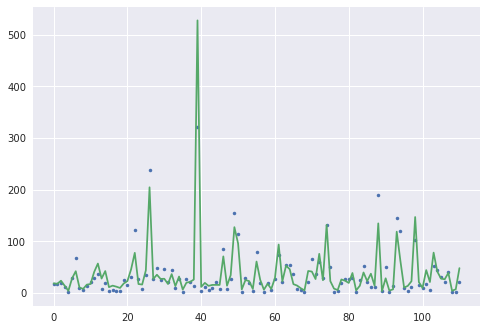

In [105]:
# make predictions based on test data split
pred = gridSearch.predict(feature_test)

# plot predictions (regression) vs target (truth)
x = np.arange(len(pred))
plt.figure()
plt.plot(x, target_test, '.')
plt.plot(x, pred, '-')
plt.show()

In [106]:
# print results
print('mean_absolute_error:', mean_absolute_error(target_test, pred))
print('mean_squared_error:', mean_squared_error(target_test, pred))
print('median_absolute_error:', median_absolute_error(target_test, pred))
print('r2_score:', r2_score(target_test, pred))

('mean_absolute_error:', 12.185602507269172)
('mean_squared_error:', 611.24329649936487)
('median_absolute_error:', 6.81111111111111)
('r2_score:', 0.73899231975515822)


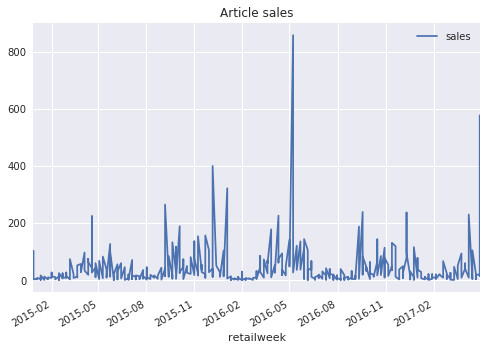

In [60]:
plt.figure()
data_EZ8648.plot( x = 'retailweek', y = 'sales')
plt.title('Article sales')
plt.show()

For this analysis, I ended up using a random forest regressor that used the following 5 features:
- promo1
- promo2
- cost'
- regular_price
- week

My forecasting with the random forest regressor on 30% of the original data that I held out for testing and validating the regressor resulted in good performance: a tested r^2 of 0.67 and a mean square error of 753.85. The mean absolute error is 15.95 and the median absolute error is 8.

## 4. Identify which type of promotion is driving more sales 

I'll approach the search for which promotion is better by grouping the sales numbers for when a promotion occurs (either promo1 or promo2) and see which has higher sales numbers. This is a gross and likely inaccurate way to find the best promotion, but it will work for a best effort given the time restrictions of the case study.

Next, I'll look into how the two promotions look when compared with sales data.

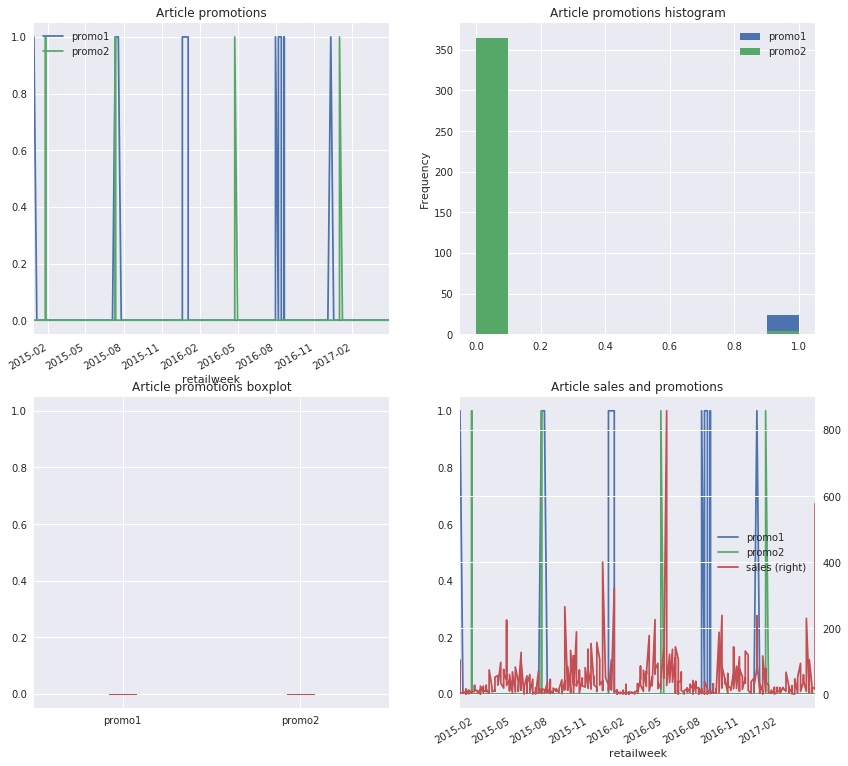

In [74]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (14,14))
data_EZ8648.plot(ax = axes[0,0], x = 'retailweek', y = ['promo1', 'promo2'])
axes[0,0].set_title('Article promotions')

data_EZ8648.plot(ax = axes[0,1], y = ['promo1', 'promo2'], kind = 'hist')
axes[0,1].set_title('Article promotions histogram')

data_EZ8648.plot(ax = axes[1,0], y = ['promo1', 'promo2'], kind = 'box')
axes[1,0].set_title('Article promotions boxplot')

data_EZ8648.plot(ax = axes[1,1], x = 'retailweek', y = ['promo1', 'promo2'])
data_EZ8648.plot(ax = axes[1,1], secondary_y = True, x = 'retailweek', y = 'sales')
axes[1,1].set_title('Article sales and promotions')
plt.show()


There are both promo1 and promo2 occurrances with this subset of data. Let's better understand 

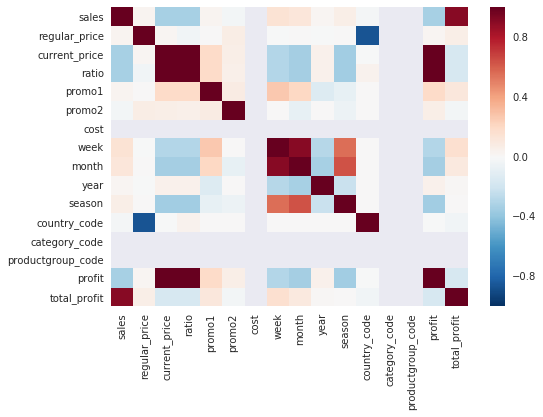

In [75]:
correlated_articleSales = data_EZ8648.corr()
sns.heatmap(correlated_articleSales)
plt.show()

I see similar correlations as to when I looked at the entire dataset. I'll see if I can do some seasonal decomposition on the data.

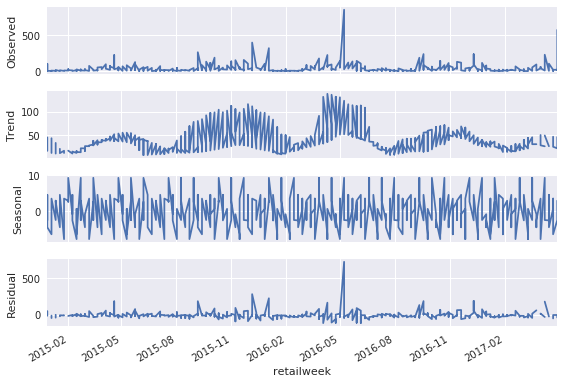

In [76]:
data_EZ8648_dt = data_EZ8648.copy()

decompFreq = 1*3*4

data_EZ8648_dt.reset_index(inplace=True)
data_EZ8648_dt = data_EZ8648_dt.set_index('retailweek')

decomp_articleSales = seasonal_decompose(data_EZ8648_dt.sales, model = 'additive', freq = decompFreq) 
decomp_articleSales.plot()
plt.show()

Find the number of promo1 instances, mean value, median value, max/min values, etc. with the pandas describe function and find the sum of total sales. Repeat for promo2.

In [77]:
data_EZ8648.groupby(by=['promo1'])['sales'].describe()

,count,mean,std,min,25%,50%,75%,max
promo1,,,,,,,,
0,345.0,40.327536,70.963715,1.0,8.00,20.0,47.0,858.0
1,24.0,48.333333,79.270405,1.0,7.75,14.0,49.0,322.0


In [78]:
data_EZ8648.groupby(by=['promo1'])['sales'].sum()

promo1
0    13913
1     1160
Name: sales, dtype: int64

In [79]:
data_EZ8648.groupby(by=['promo2'])['sales'].describe()

,count,mean,std,min,25%,50%,75%,max
promo2,,,,,,,,
0,365.0,41.024658,71.785333,1.0,8.0,19.0,47.00,858.0
1,4.0,24.750000,22.425804,3.0,7.5,23.0,40.25,50.0


In [80]:
data_EZ8648.groupby(by=['promo2'])['sales'].sum()

promo2
0    14974
1       99
Name: sales, dtype: int64

One thing to point out before I make some declarations as to which promotion is better is that the sample size difference of the number of occurances of promotion 1 (1160) is significant when compared to the much smaller sample size for the number of occurances for promotion 2 (4). This in itself makes the comparison challenging and makes my inspection into the total sum of sales when each promotion is active useless. An important thing to note is that I didn't fit in a check for if the two promotions overlapped in the grouping above. I'll re-analyze the promotion data by conditionally grouping the data such that when one of the promotions is occurring (set to 1) the other promotion is not occurring.

In [81]:
data_EZ8648[(data_EZ8648.promo1 == 1) & (data_EZ8648.promo2 == 1)].shape

(1, 21)

There 1 instance where both promo1 and promo2 are happening at the same time. Perform conditional groupby filtering so that the promotions are looked at on their own.


In [82]:
g_p1 = data_EZ8648.groupby(by=['promo1'])
g_p1.apply(lambda x: x[x['promo2'] != 1]['sales'].describe())

sales,count,mean,std,min,25%,50%,75%,max
promo1,,,,,,,,
0,342.0,40.400585,71.252805,1.0,8.0,20.0,47.0,858.0
1,23.0,50.304348,80.448422,1.0,10.0,14.0,59.0,322.0


The mean value for promo1 increases from 48.33 to 50.30 sales per week and the median value remains constant relative to sales per week with promo1 activated and promo2 off.

In [84]:
g_p1.apply(lambda x: x[x['promo2'] != 1]['sales'].sum())

promo1
0    13817
1     1157
dtype: int64

In [85]:
g_p2 = data_EZ8648.groupby(by=['promo2'])
g_p2.apply(lambda x: x[x['promo1'] != 1]['sales'].describe())

sales,count,mean,std,min,25%,50%,75%,max
promo2,,,,,,,,
0,342.0,40.400585,71.252805,1.0,8.0,20.0,47.0,858.0
1,3.0,32.000000,20.952327,9.0,23.0,37.0,43.5,50.0
